In [40]:
import scipy.io
import scipy
import numpy
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
import matplotlib.pyplot as plt
import pandas
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from jupyterthemes import jtplot
jtplot.style()

#read in training data
x_train = scipy.io.loadmat('16shells/TrainSignals_16shells_NF.mat')
TrainSig = x_train['TrainSignals_16shells_NF']
y_train = scipy.io.loadmat('16shells/TrainParams.mat')
TrainParam = y_train['TrainParams']

#read in test data
x_test = scipy.io.loadmat('16shells/TestSignals_16shells_NF.mat')
TestSig = x_test['TestSignals_16shells_NF']
y_test = scipy.io.loadmat('16shells/TestParams.mat')
TestParam = y_test['TestParams']

#scale radius, permeability for estimation
TrainParam[:,4]=TrainParam[:,4]*1e9

x=len(TrainParam)
TrainParams=numpy.ndarray(shape=(x,3))
TrainParams[:,0]=TrainParam[:,0] # VF
TrainParams[:,1]=TrainParam[:,3] # tau
TrainParams[:,2]=TrainParam[:,4] # diff

# Define the scaler
scaler = StandardScaler().fit(TrainSig)
# Scale the train set
TrainSig = scaler.transform(TrainSig)
# Scale the test set
TestSig = scaler.transform(TestSig)

In [41]:
# #set up the regressor
# reg = RandomForestRegressor(n_estimators=100,max_features="sqrt",max_depth=20)

# #fit the regressor
# reg.fit(TrainSig,TrainParams)

# # compute importances of features
# importances = reg.feature_importances_

# std = numpy.std([tree.feature_importances_ for tree in reg.estimators_],axis=0)
# indices = numpy.argsort(importances)[::-1]

# # Print the feature ranking
# # print("Feature ranking:")
# # for f in range(TrainSig.shape[1]):
# #     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# TrainSig = reg.transform(TrainSig, threshold=0.001) 
# TestSig = reg.transform(TestSig, threshold=0.001)

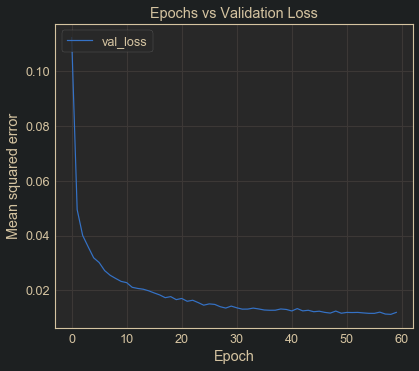

In [42]:
# create model
numpy.random.seed(2)
model = Sequential()
hidden_units = 300
dropout_rate = 0.45
e = 60
# model.add(Dropout(0.1,input_shape=(TrainSig.shape[1],)))
model.add(Dense(input_dim=TrainSig.shape[1],
                kernel_initializer='he',
                activation='relu',
                units=hidden_units))
model.add(Dropout(dropout_rate))
model.add(Dense(input_dim=hidden_units,
                kernel_initializer='normal',
                activation='relu',
                units=hidden_units))
model.add(Dropout(dropout_rate))
model.add(Dense(input_dim=hidden_units,
                kernel_initializer='normal',
                units=TrainParams.shape[1]))
# Compile model
model.compile(loss='mean_squared_error', optimizer='Adam')
history = model.fit(TrainSig,
         TrainParams,
         epochs=e,
         batch_size=50,
         verbose=0,
         validation_split=0.1)

# summarize history for accuracy
plt.plot(history.history['loss'])
plt.title('Epochs vs Validation Loss')
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
plt.legend(['val_loss'], loc='upper left')
plt.show()

(0.97336759168332698, 0.0)
(0.99600654926737675, 0.0)
(0.8599306870998954, 0.0)


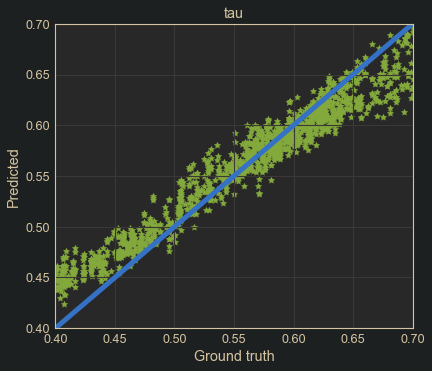

In [45]:
# predict test values using NN
TestPredict = model.predict(TestSig)

# Plotting results
score=scipy.stats.pearsonr(TestParam[:,0],TestPredict[:,0])
print(score) # VF
score=scipy.stats.pearsonr(TestParam[:,4],TestPredict[:,2])
print(score) # diff
score=scipy.stats.pearsonr(TestParam[:,3],TestPredict[:,1])
print(score) # tau

x=[0,1]
y=[0,1]
plt.plot(x,y,'b-',linewidth=5.0)
plt.scatter((TestParam[:,0]),TestPredict[:,0],c='g',s=50,marker=(5,1))
plt.title('tau')
plt.xlabel('Ground truth')
plt.ylabel('Predicted')
plt.xlim([0.4,0.7])
plt.ylim([0,0.7])
plt.show(block=True)

In [20]:
# save as a .mat file
data = {}
data['TestPredict_NN_sig'] = TestPredict
scipy.io.savemat('results_ismrm/TestPredict_NN_sig_NF.mat',data)

In [ ]:
numpy.average(TestPredict,axis=0)

In [ ]:
# 4 shells NF                      SNR40
# epochs=100                        15 epochs
# batch_size=50                     batch_size=50, 350 hidden units
 (0.99540963356208068, 0.0)       (0.92565519574520061, 0.0)
 (0.99978113251288825, 0.0)       (0.99167112526627699, 0.0)
 (0.90468673496800545, 0.0)       (0.43072966404618124, 1.2567409506660723e-65)

In [ ]:
# 8 shells   NF                    SNR40
(0.99313225714157327, 0.0)         (0.94610877157161444, 0.0)
(0.99958329555621428, 0.0)         (0.99249789104288588, 0.0)
(0.89552562317681639, 0.0)         (0.4744726458693484, 4.1159114767839645e-81)


In [ ]:
#  16 shells                       SNR40

(0.99046457957287948, 0.0)          (0.92817112876461738, 0.0)
(0.99946933914998681, 0.0)          (0.98586872149859328, 0.0)
(0.87000788568211596, 0.0)          (0.47947096787399918, 4.980861099001512e-83)

In [ ]:
# bVal shells                       SNR40

 (0.99555053662671011, 0.0)         (0.93336177035517864, 0.0)
 (0.99965793836980887, 0.0)         (0.98828200246513942, 0.0)
 (0.92982345282265688, 0.0)         (0.48217242485408263, 4.444435899070114e-84)